In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nba-scrapped-data-1991-2022/full_stats_1991_2022.xlsx
/kaggle/input/nba-scrapped-data-1991-2022/mvp_1991_2022.xlsx
/kaggle/input/nba-scrapped-data-1991-2022/team_1991_2022.xlsx
/kaggle/input/nba-scrapped-data-1991-2022/team_nicknames.txt
/kaggle/input/nba-scrapped-data-1991-2022/players_1991_2022.xlsx


# Problem Statement: 
   To create a model that is able to predict MVP rankings for the current season. 

# Work Flow:
1. Create a base model to compare it and improve the base model using optimizations/hypertuning
2. Implement other solution as:
        Two process approach:
            1. Create a classification model and identify players in MVP votings for next season (add MVP label into data)
            2. Predict rankings on the predicted MVP players using regression or other advance model
            3. Improve/Visualizations
3. As the problem is of ranking entities, we need custom model evaluation metric. The chosen evaluation metric is Average Precision. 
More about it: 
https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832 + References

4. Try:
    1. Moving-windows/weighted regression analysis
    2. LTSM neural network



## Previous Seasons --> All Players --> Train Classification Model for MVP label
## Previous Seasons --> Subset on Players in MVP list --> Train Regression Model

## New Season --> Identify MVP players --> Predict Share using Regression --> Rank Players

In [43]:
#Importing Libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
#from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
#from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
#from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import make_scorer

In [9]:
# Reading file which was already compiled using data-scraping.
full_stats = pd.read_excel("/kaggle/input/nba-scrapped-data-1991-2022/full_stats_1991_2022.xlsx", sheet_name="Sheet1", index_col = "Unnamed: 0")

#Labeling Players selected for MVP voting
full_stats['MVP_flag'] = np.where(full_stats['Share']>0, 1, 0)
full_stats

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,Share,Team,W,L,W/L%,GB,PS/G,PA/G,SRS,MVP_flag
0,A.C. Green,PF,27,LAL,82,21,26.4,3.1,6.6,0.476,...,0.0,Los Angeles Lakers,58,24,0.707,5.0,106.3,99.6,6.73,0
1,Byron Scott,SG,29,LAL,82,82,32.1,6.1,12.8,0.477,...,0.0,Los Angeles Lakers,58,24,0.707,5.0,106.3,99.6,6.73,0
2,Elden Campbell,PF,22,LAL,52,0,7.3,1.1,2.4,0.455,...,0.0,Los Angeles Lakers,58,24,0.707,5.0,106.3,99.6,6.73,0
3,Irving Thomas,PF,25,LAL,26,0,4.2,0.7,1.9,0.340,...,0.0,Los Angeles Lakers,58,24,0.707,5.0,106.3,99.6,6.73,0
4,James Worthy,SF,29,LAL,78,74,38.6,9.2,18.7,0.492,...,0.0,Los Angeles Lakers,58,24,0.707,5.0,106.3,99.6,6.73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14692,Spencer Hawes,PF,28,MIL,54,1,14.8,2.5,5.1,0.484,...,0.0,Milwaukee Bucks,42,40,0.512,9.0,103.6,103.8,-0.45,0
14693,Steve Novak,PF,33,MIL,8,0,2.8,0.3,0.9,0.286,...,0.0,Milwaukee Bucks,42,40,0.512,9.0,103.6,103.8,-0.45,0
14694,Terrence Jones,PF,25,MIL,54,12,23.5,4.3,9.1,0.470,...,0.0,Milwaukee Bucks,42,40,0.512,9.0,103.6,103.8,-0.45,0
14695,Thon Maker,C,19,MIL,57,34,9.9,1.5,3.2,0.459,...,0.0,Milwaukee Bucks,42,40,0.512,9.0,103.6,103.8,-0.45,0


In [10]:
predictors = ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P','3PA', '3P%', '2P', '2PA', 
             '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB','DRB', 'TRB', 'AST', 'STL', 'BLK', 
             'TOV','PF', 'PTS', 'Year', 'W', 'L', 'W/L%', 'GB', 'PS/G','PA/G', 'SRS']
# train classification model --> classify
# within training set regression model train on mvps
# regression model is to be trained on all the players that received 

#a function that can separate selected year to evaluate from previous years
def test_train_year(data, test_year):
    all_years_values = np.unique(data.Year)
    training_years = all_years_values[all_years_values<test_year]
    train_set = data[data.Year.isin(training_years)]
    test_set = data[data.Year==test_year]
    return train_set, test_set

#using training set, predict Share of votings using player stats who are labeled as MVP

#WHY? As this is an unbalanced dataset with only handful of players selected for MVP voting, it makes sense to 
#train regression model only on players selected for voting.
#Here response variable is 'Share'
def reg_data(train_set):
    global predictors
    reg_train_data = train_set[train_set['MVP_flag']==1][predictors]
    reg_y_train = train_set[train_set['MVP_flag']==1]['Share']

    #reg_test_data = test_set['MVP_flag'==1][predictors]
    #reg_y_test = test_set['MVP_flag'==1]['Score']                 #to evaluate regression model
    return reg_train_data, reg_y_train

#Response variable is 'MVP_flag'
def classification_data(train_set, test_set):
    global predictors
    class_train_data = train_set[predictors]
    class_y_train = train_set['MVP_flag']
    
    class_test_data = test_set[predictors]
    class_y_test = test_set['MVP_flag']
    return class_train_data, class_y_train, class_test_data, class_y_test
 
#To evaluate classification model
def cf_model_eval(model, class_train_data, class_y_train, class_test_data, class_y_test):
    global predictors
    model.fit(class_train_data, class_y_train)
    predictions = model.predict(class_test_data)
    
    cf_model_eval.cf_mat_test = confusion_matrix(class_y_test, predictions)
    cf_model_eval.roc_score = roc_auc_score(class_y_test, model.predict_proba(class_test_data)[:,1])
   
    mvp_data = class_test_data.assign(predictions=predictions) 
    predicted_mvp = mvp_data[mvp_data['predictions']==1][predictors]
    
    return predicted_mvp

#trainig regression model on the data
def reg_model(model, reg_train_data, reg_y_train, predicted_mvp):
    model.fit(reg_train_data, reg_y_train)
    predictions = model.predict(predicted_mvp)
    predicted_data = predicted_mvp.assign(pred_score = predictions).sort_values('pred_score', ascending=False)
    predicted_data["pred_rank"] = list(range(1, predicted_data.shape[0]+1))
    return predicted_data

#adding predicted and actual rankng to actual data
def compare_rankings(test_set, predicted_data):
    test_set = test_set.sort_values('Share', ascending=False)
    test_set["Rank"] = list(range(1, test_set.shape[0]+1))
    rankings = pd.merge(test_set, predicted_data[["pred_rank"]], how='outer', left_index=True, right_index=True)
    rankings = rankings.sort_values("Rank", ascending=True)
    return rankings

#defining average precison function to evaluate model performance
def ap_evaluation(rankings):                                #average precision evaluation, AP@5, at 5 rankings
    actual = rankings.sort_values("Rank").head(5)
    predicted = rankings.sort_values("pred_rank")
    precision_score = []
    found = 0
    counter = 1
    for index,row in predicted.iterrows():
        if row["Player"] in actual["Player"].values:
            found += 1
            precision_score.append(found/counter)
        counter += 1

    return sum(precision_score) / len(precision_score)


# Base Model: Ridge Regression

In [62]:
years = [year for year in range(1996, 2023)]
regression_model = Ridge()
eval_scores = []

for year in years:
    train_set, test_set = test_train_year(full_stats, year)
    reg_train_data, reg_y_train = reg_data(train_set)
    prediction_data = reg_model(regression_model,reg_train_data, reg_y_train, test_set[predictors])
    rankings = compare_rankings(test_set, prediction_data)
    
    eval_scores.append(ap_evaluation(rankings))

sum(eval_scores)/len(eval_scores)

0.8297599108710221

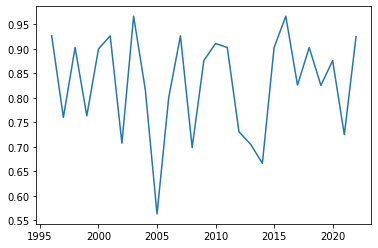

In [63]:
plt.plot(years, eval_scores)
plt.show()

In [57]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
years = [year for year in range(1996, 2023)]
regression_model = Ridge()
eval_scores = []
param_d = {}
kf = KFold(n_splits=4)
param_grid={'alpha':np.arange(0.01,1,0.02), 'solver':['sag','auto', 'lsqr']}

for year in years:
    train_set, test_set = test_train_year(full_stats, year)
    reg_train_data, reg_y_train = reg_data(train_set)
    
    ridge_cv = RandomizedSearchCV(regression_model, param_grid, cv=kf, n_jobs=-1)
    ridge_cv.fit(reg_train_data, reg_y_train)
    
    eval_scores.append(ridge_cv.best_score_)
    param_d[year] = [ridge_cv.best_params_]
    
sum(eval_scores)/len(eval_scores)

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


0.4004582597180335

# 2 Process Approach

In [58]:
from sklearn.ensemble import HistGradientBoostingClassifier
years = [year for year in range(1997, 2023)]
metric = []

#classification_model = RandomForestClassifier()
classification_model = HistGradientBoostingClassifier()
regression_model = Ridge(solver='sag', alpha=0.7)

for year in years:    
    train_set, test_set = test_train_year(full_stats, year)
    class_train_data, class_y_train, class_test_data, class_y_test = classification_data(train_set, test_set)
    reg_train_data, reg_y_train = reg_data(train_set)
   
    predicted_mvp = cf_model_eval(classification_model, class_train_data, class_y_train, class_test_data, class_y_test)    
    prediction_data = reg_model(regression_model,reg_train_data, reg_y_train, predicted_mvp)

    rankings = compare_rankings(test_set, prediction_data)
    metric.append(ap_evaluation(rankings))

#Averaging the metrics over the years
sum(metric)/len(metric)

[0.7753968253968253,
 0.8766666666666666,
 0.8392857142857142,
 0.876923076923077,
 0.9428571428571428,
 0.7551948051948052,
 0.9428571428571428,
 0.9028571428571428,
 0.5709090909090909,
 0.821111111111111,
 0.9266666666666665,
 0.7688235294117647,
 0.9266666666666665,
 0.925,
 0.9266666666666665,
 0.7944444444444445,
 0.7253968253968253,
 0.6588235294117647,
 0.9266666666666665,
 0.9666666666666666,
 0.8261904761904761,
 0.9666666666666666,
 0.821111111111111,
 0.9028571428571428,
 0.7088888888888889,
 0.925]

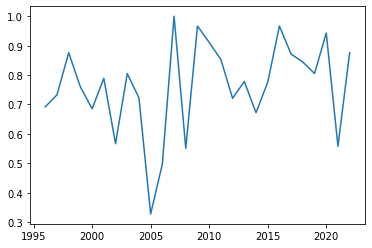

In [126]:
#Visualizing metrics over years:
plt.plot(years, metric)
plt.show()

In [60]:
sum(metric)/len(metric)

0.846176717952736

Here we have improved our model performance to 84% on average precision @ 5 rankings. The last precison for year 2022 scored 92.5%.